In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings, copy
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tabulate import tabulate
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load data
onlinefraud = pd.read_csv("/content/fraud_detection_dataset.csv")
print(onlinefraud.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## Analysis of Dataset

In [ ]:
onlinefraud.describe().round(3)
onlinefraud.info()
onlinefraud.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
fraud_min_max = [
    ['amount', onlinefraud.amount.min(), onlinefraud.amount.max()],
    ['oldbalanceOrg', onlinefraud.oldbalanceOrg.min(), onlinefraud.oldbalanceOrg.max()],
    ['newbalanceOrig', onlinefraud.newbalanceOrig.min(), onlinefraud.newbalanceOrig.max()],
    ['oldbalanceDest', onlinefraud.oldbalanceDest.min(), onlinefraud.oldbalanceDest.max()],
    ['isFraud', onlinefraud.isFraud.min(), onlinefraud.isFraud.max()]
]

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='orgtbl',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----+----------------+-------------+-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [ ]:
# Downcast numerical columns with smaller dtype

df = onlinefraud
for col in onlinefraud.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [ ]:
df.duplicated().sum()

0

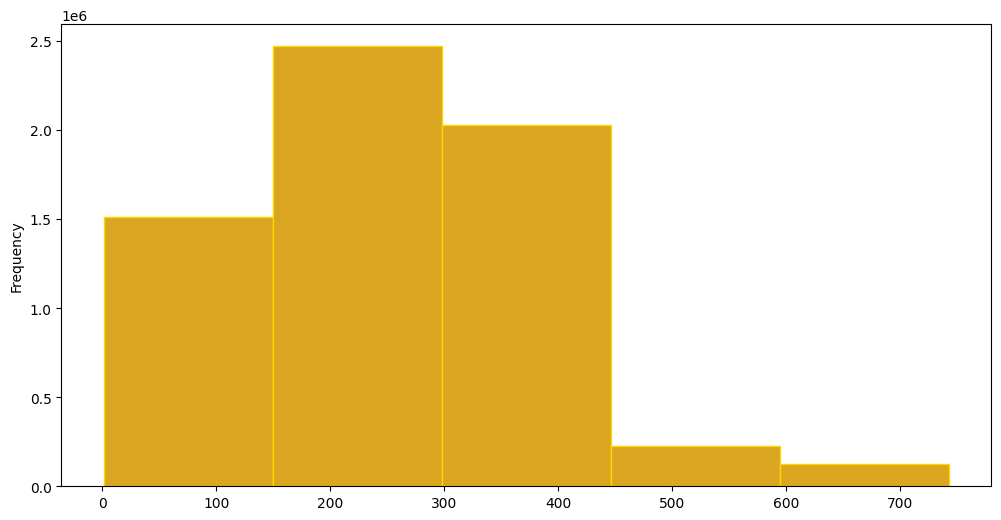

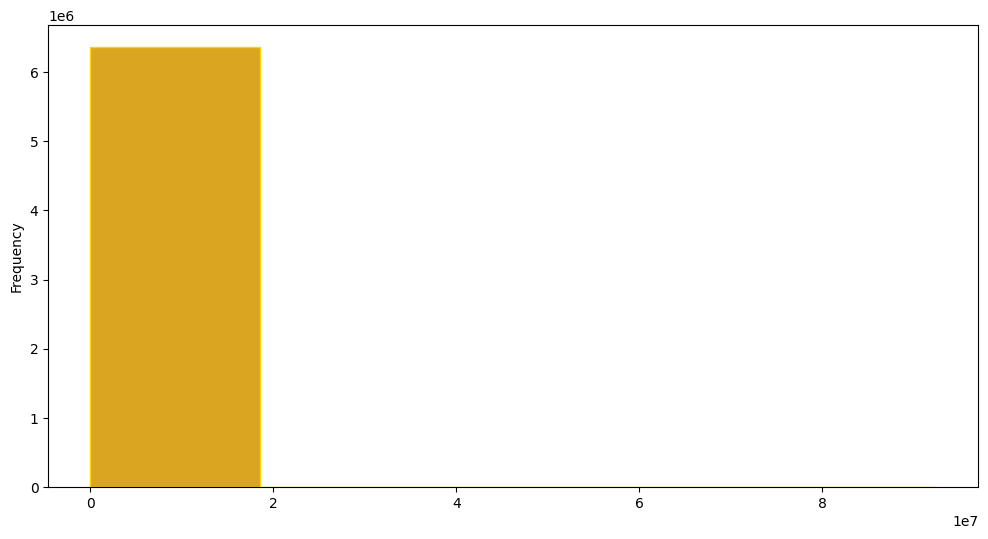

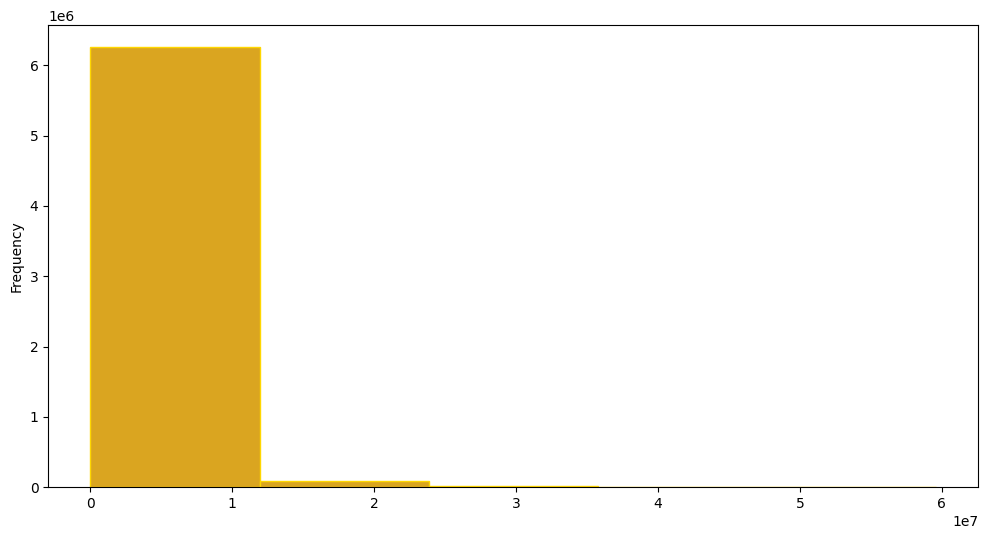

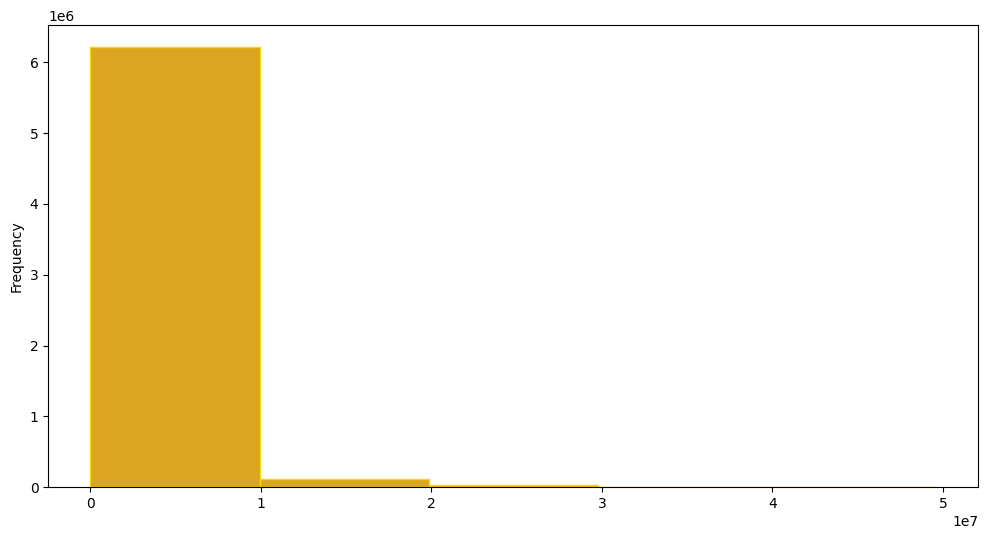

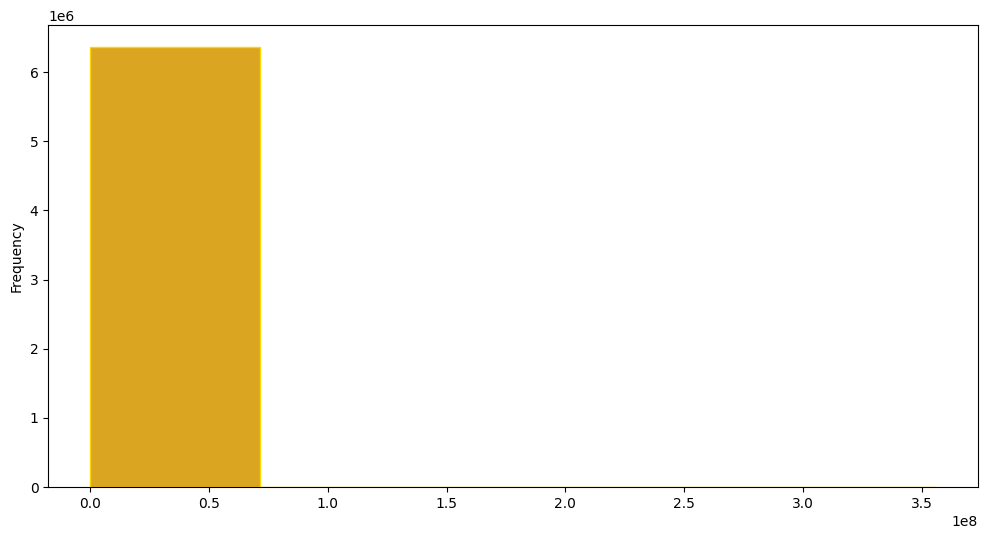

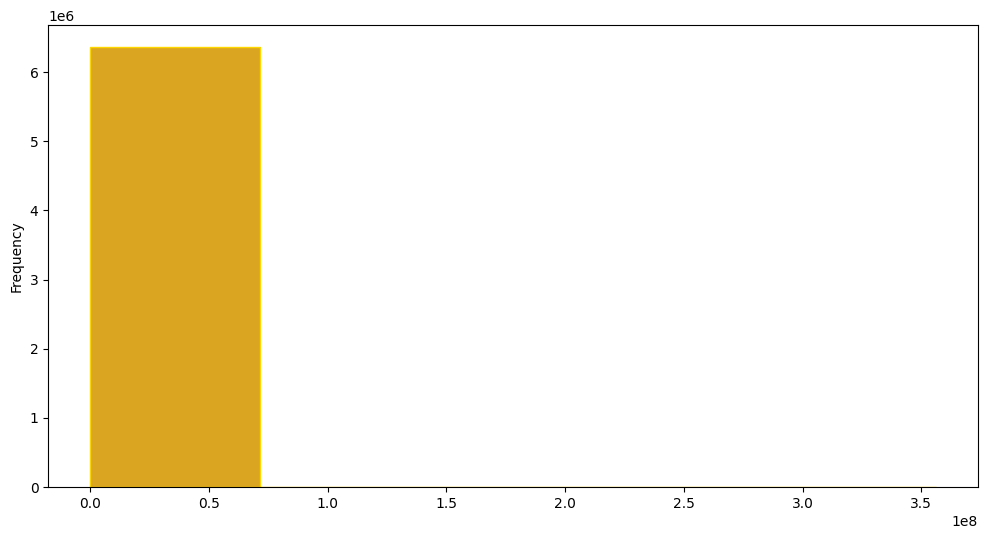

In [ ]:
%matplotlib inline

feature=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    plt.xlabel(i)
    df[i].plot(kind='hist', bins=5, figsize=(12,6), facecolor='goldenrod',edgecolor='gold')
    plt.show()

In [ ]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    print(i)
    print(df[i].quantile(0.10))
    print(df[i].quantile(0.90))

    print('\n')

amount
4501.3
365423.30900000007


oldbalanceOrg
0.0
1822508.289000007


newbalanceOrig
0.0
1970344.7930000005


oldbalanceDest
0.0
2914266.6690000016


newbalanceDest
0.0
3194869.671000002




In [ ]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    lower = df[i].quantile(0.10)
    upper = df[i].quantile(0.90)
    df[i] = np.where(df[i] <lower, lower,df[i])
    df[i] = np.where(df[i] >upper, upper,df[i])
    print('Feature: ',i)
    print('Skewness value: ',df[i].skew())
    print('\n')

Feature:  amount
Skewness value:  0.8046460444556197


Feature:  oldbalanceOrg
Skewness value:  2.249361299814406


Feature:  newbalanceOrig
Skewness value:  2.2262847493216786


Feature:  oldbalanceDest
Skewness value:  1.4173123924260833


Feature:  newbalanceDest
Skewness value:  1.3593024983493058




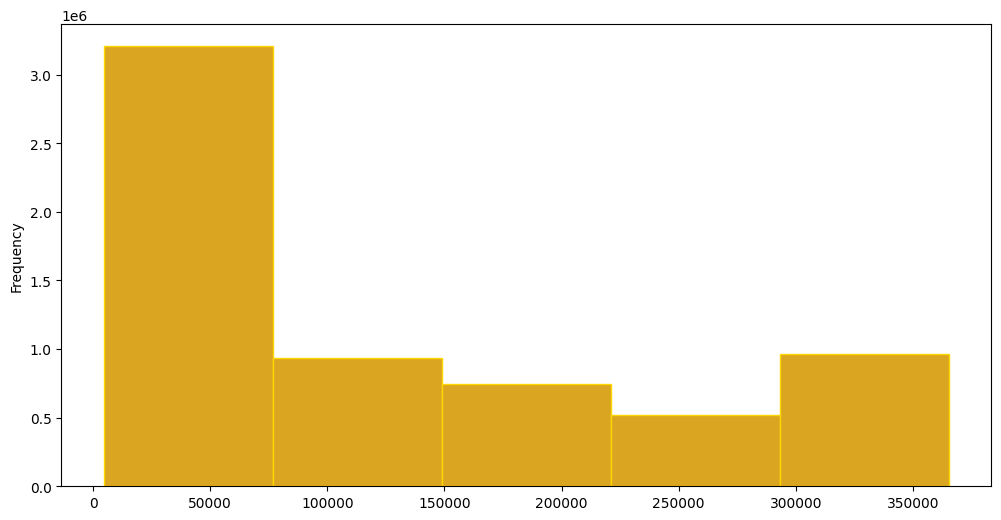

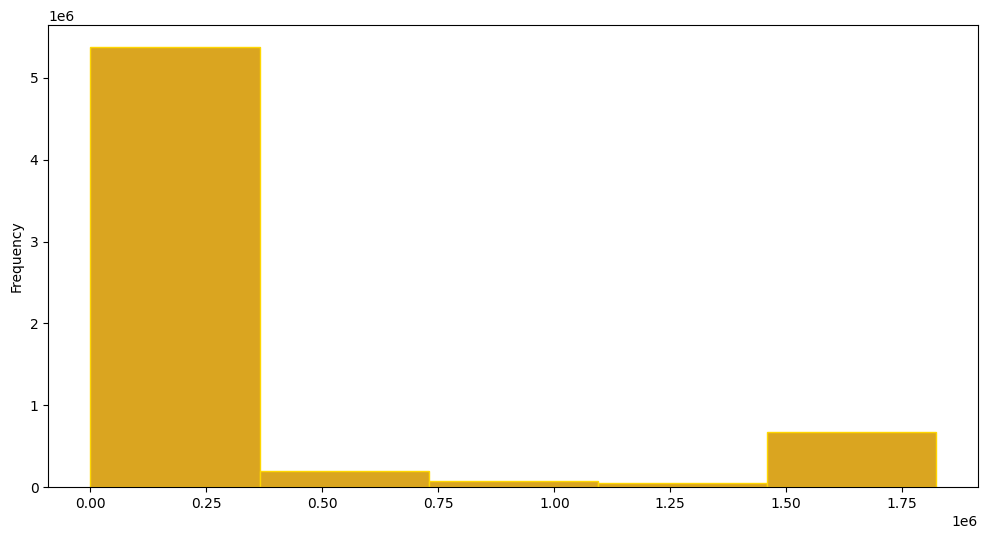

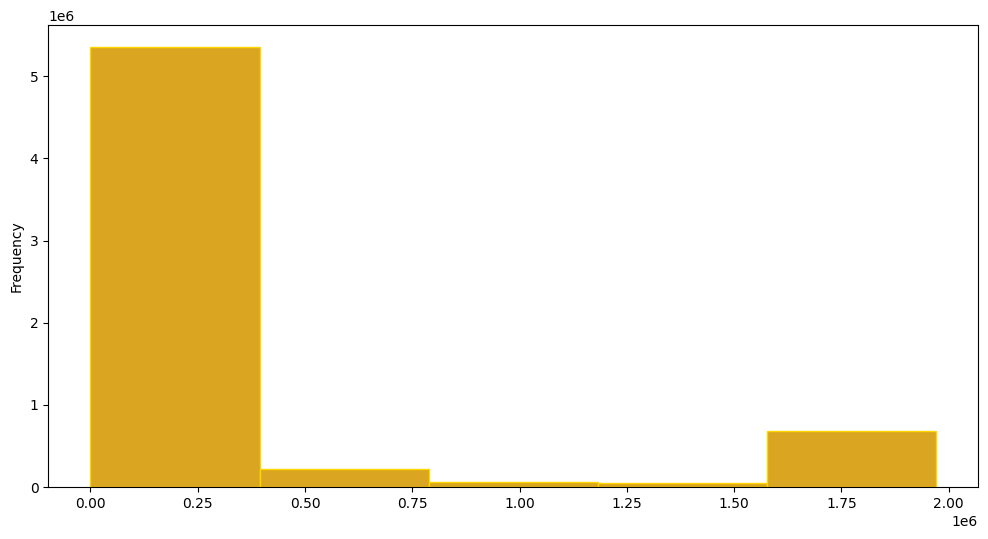

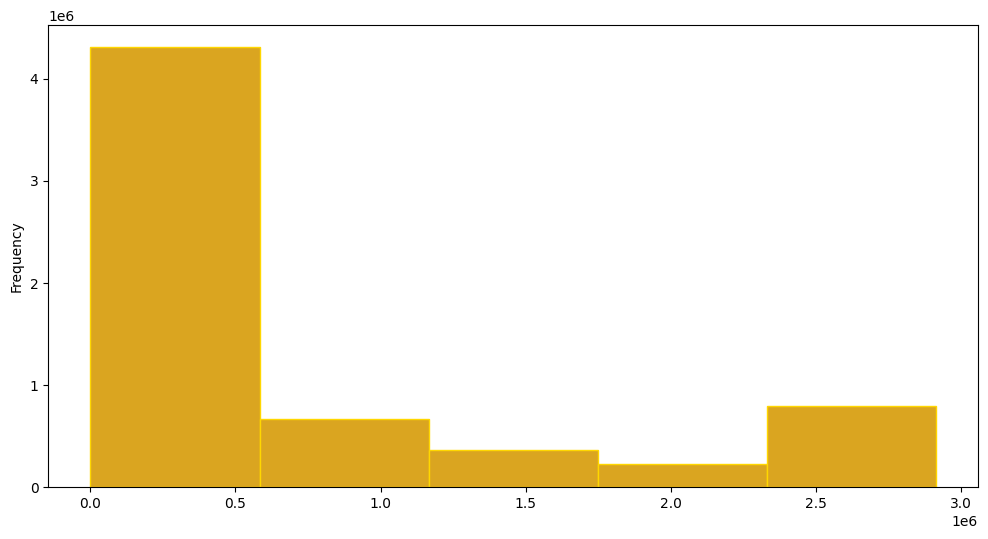

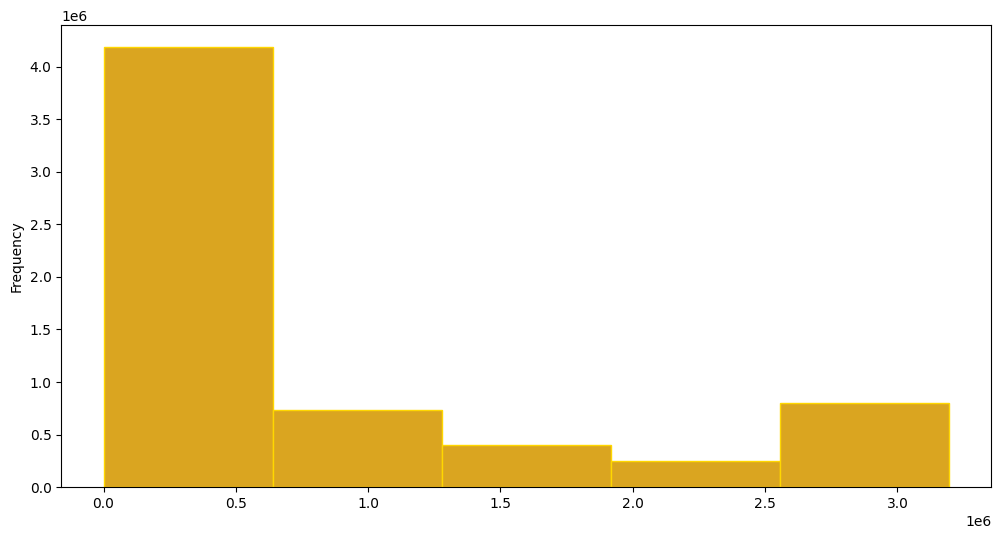

In [ ]:
feature=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in feature:
    plt.xlabel(i)
    df[i].plot(kind='hist', bins=5, figsize=(12,6), facecolor='goldenrod',edgecolor='gold')
    plt.show()

We have a maximum set of distribution between 150 to 400 of step After outlier treatment
Amount ranges between 0-35 lakhs with more values ranging between 0-75,000. We'll analyze further in the upcoming sections.
OldbalanceOrg ranges around 0-18 lakh with more frequency around 0-375,000
NewbalanceOrig ranges around 0-19 lakh with more frequency around 0-375,000
OldbalanceDest ranges around 0-29 lakh with common values around 0-625,000
NewbalanceDest ranges around 0-35 lakh with common values around 0-625,000

## Type

In [ ]:
df.type

,type
0,PAYMENT
1,PAYMENT
2,TRANSFER
3,CASH_OUT
4,PAYMENT
...,...
6362615,CASH_OUT
6362616,TRANSFER
6362617,CASH_OUT
6362618,TRANSFER


In [ ]:
df.type.unique()

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
Categories (5, object): ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

In [ ]:
payment = df.type.value_counts()
payment

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


<Axes: ylabel='type'>

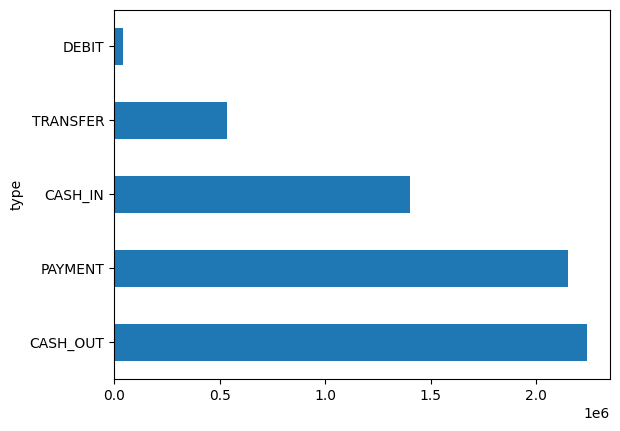

In [ ]:
payment.plot(kind='barh')

<Axes: xlabel='type', ylabel='count'>

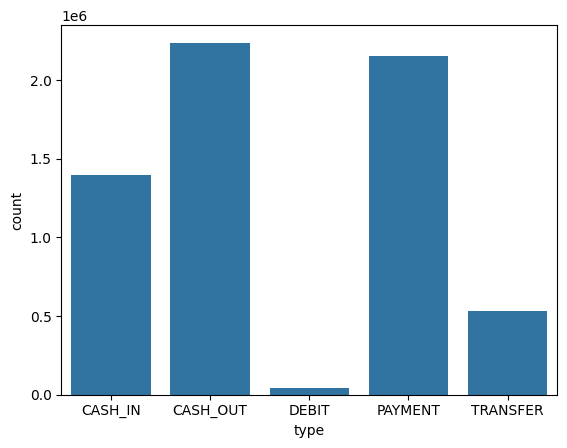

In [ ]:
sns.countplot(x='type', data=df)

More money has been transacted mostly through cash out followed by payment type.


## Relationship with type column "isFraud"

In [ ]:
CrosstabResult=pd.crosstab(index=df.type,columns=df.isFraud)
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [ ]:
#with fraud happened type
CrosstabResult[1]

,1
type,
CASH_IN,0
CASH_OUT,4116
DEBIT,0
PAYMENT,0
TRANSFER,4097


We can see that fraud occurred mostly while during transfer or cashout. But the numbers indicating fraud happened with fraud not happened is very low. So it'll not be seen in the plot.

<Axes: xlabel='type'>

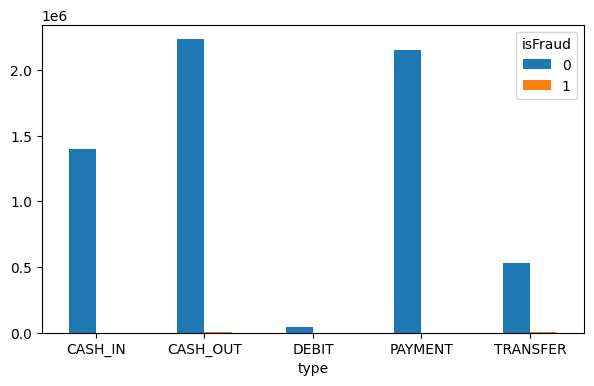

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

<Axes: xlabel='type'>

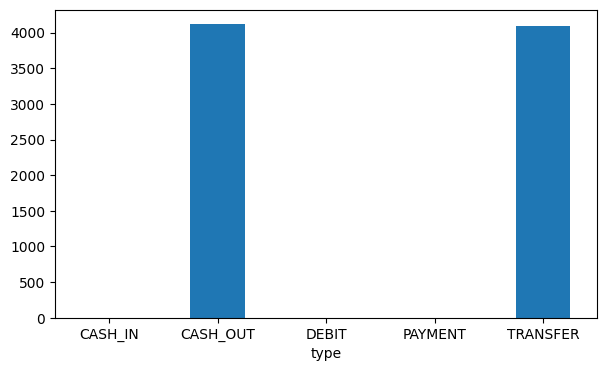

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD with maximizing
CrosstabResult[1].plot.bar(figsize=(7,4), rot=0)

(3500.0, 7000.0)

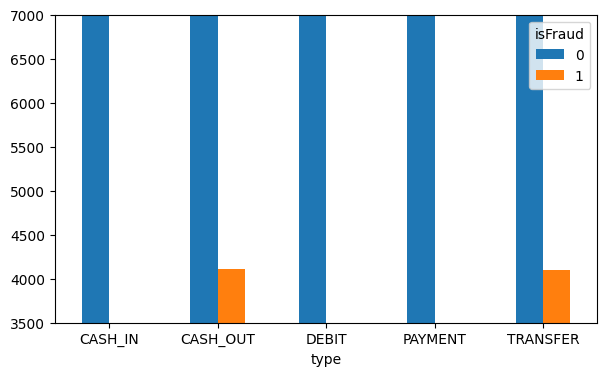

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD by changing ylimit to view isFraud values
CrosstabResult.plot.bar(figsize=(7,4), rot=0)
plt.ylim([3500, 7000])

In [ ]:
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [ ]:
cashout=2233384+4116
cashout_fraud= 4116/(cashout) * 100
cashout_fraud

0.18395530726256984

#### 0.184 % denotes the percentage of fraud happened in total cashout mode type, which is very less%

In [ ]:
transfer= 528812+4097
transfer_fraud = 4097/(transfer) * 100
transfer_fraud

0.7687991758442811

#### 0.769 % denotes the percentage of fraud happened in total tranfer mode type, which is very also less%

In [ ]:
df.amount

,amount
0,9839.640
1,4501.300
2,4501.300
3,4501.300
4,11668.140
...,...
6362615,339682.130
6362616,365423.309
6362617,365423.309
6362618,365423.309


### Check the Minimum and Maximum range amount

<Axes: ylabel='amount'>

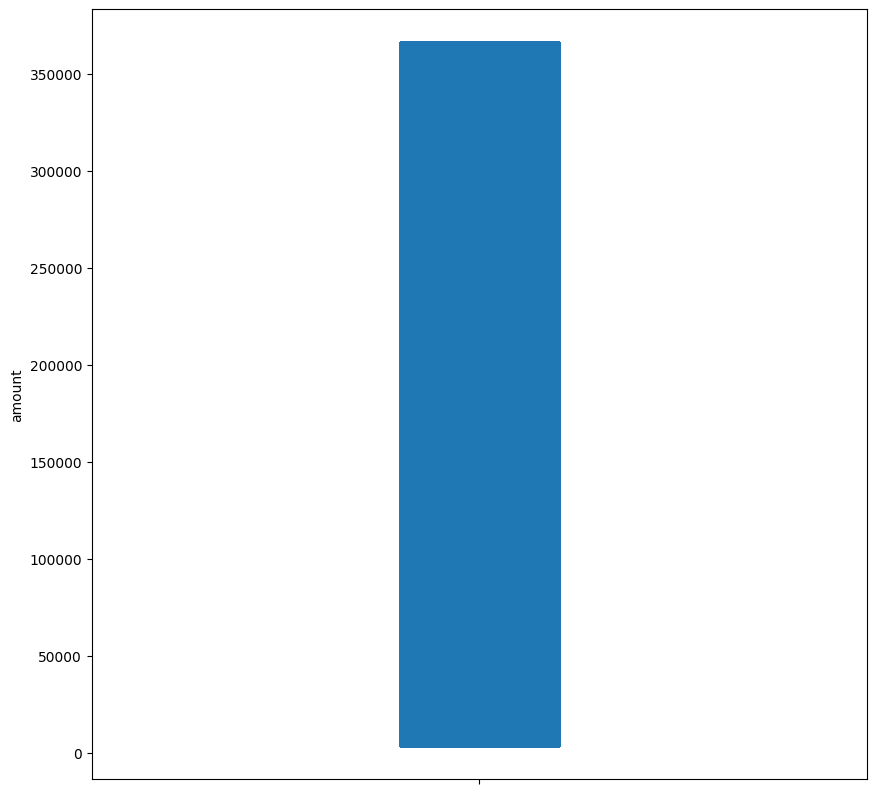

In [ ]:
plt.figure(figsize=(10,10))
sns.stripplot(y=df.amount)

In [ ]:
print('Minimum: ',df.amount.min())
print('Maximum: ',df.amount.max())

Minimum:  4501.3
Maximum:  365423.30900000007


#### Lowest amount transaction starts from 4500 and highest amount transaction goes upto  0.36 millions .
### we will check the realtionship with isFraud column

<Axes: title={'center': 'amount'}, xlabel='isFraud'>

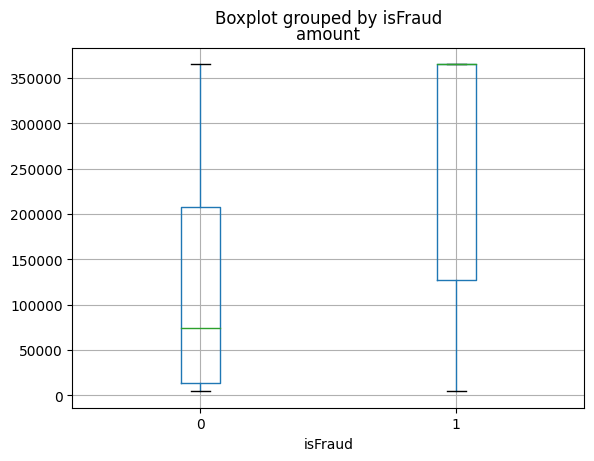

In [ ]:
df.boxplot(column='amount', by='isFraud')

#### Fraud amount transaction range is between 0.13-0.36 Millions

### isFraud

In [ ]:
total_transactions = df.shape[0]

fraud_transaction = df[df.isFraud==1].shape[0]

fraud_percent= fraud_transaction/total_transactions * 100
fraud_percent

0.12908204481801522

In [ ]:
print('Total transactions: ',total_transactions)
print('Total fraud transactions happened: ',fraud_transaction)
print("Total fraud transaction percent: ",round(fraud_percent,2))

Total transactions:  6362620
Total fraud transactions happened:  8213
Total fraud transaction percent:  0.13


In [ ]:
fraud_amount= df[df.isFraud==1]
fraud_amount=fraud_amount.sort_values(by=['amount'],ascending=False)
fraud_amount

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5188057,367,CASH_OUT,365423.309,C1210833971,435867.160,0.000,C363013236,186826.40,622693.550,1,0
5990227,416,CASH_OUT,365423.309,C2110305720,1822508.289,0.000,C225008798,523626.59,3194869.671,1,0
5990225,416,CASH_OUT,365423.309,C246726057,1822508.289,0.000,C1786144514,2423749.18,3194869.671,1,0
5990224,416,TRANSFER,365423.309,C298387535,1822508.289,1970344.793,C662194461,0.00,0.000,1,0
5988262,415,CASH_OUT,365423.309,C2137951962,1675153.280,0.000,C309573869,12832.26,1687985.530,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6002113,428,CASH_OUT,4501.300,C1838531308,3037.670,0.000,C505532836,800854.71,803892.380,1,0
6002112,428,TRANSFER,4501.300,C1408814433,3037.670,0.000,C944070846,0.00,0.000,1,0
1796322,162,TRANSFER,4501.300,C1172437299,151.000,0.000,C315826176,0.00,0.000,1,0
1796323,162,CASH_OUT,4501.300,C790340353,151.000,0.000,C517676411,386163.34,386314.340,1,0


<Axes: ylabel='Frequency'>

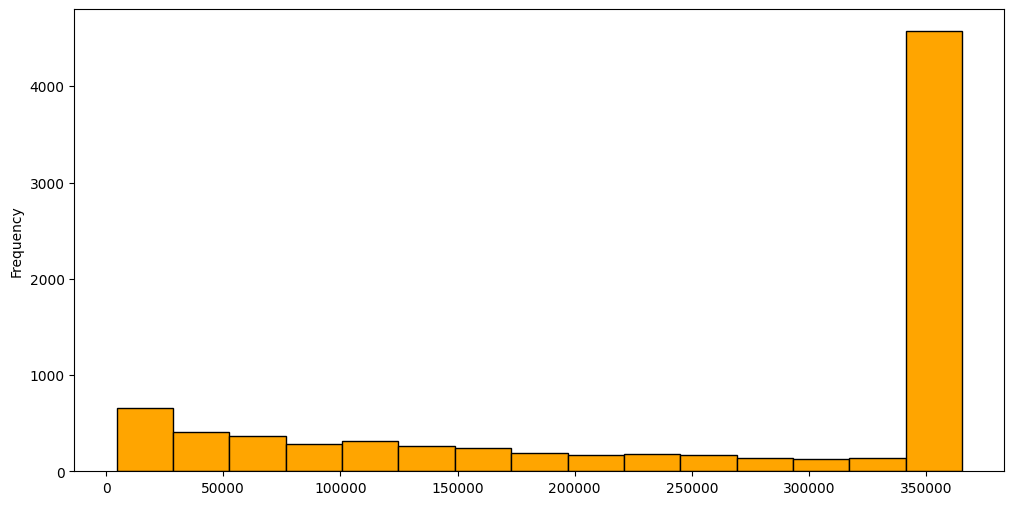

In [ ]:
fraud_amount.amount.plot(kind='hist', bins=15, figsize=(12,6), facecolor='orange',edgecolor='black')

We've found that fraud amount transaction ranges between 0.31-0.35 millions.

Now, we can see that among them most occured were around 300,000-350,000.

## nameDest

In [ ]:
fraudster= df.nameDest.value_counts()
fraudster

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
...,...
M1470027725,1
M1330329251,1
M1784358659,1


In [ ]:
fraudster[:10]

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
C1590550415,101
C451111351,99
C1789550256,99
C1360767589,98


<Axes: ylabel='nameDest'>

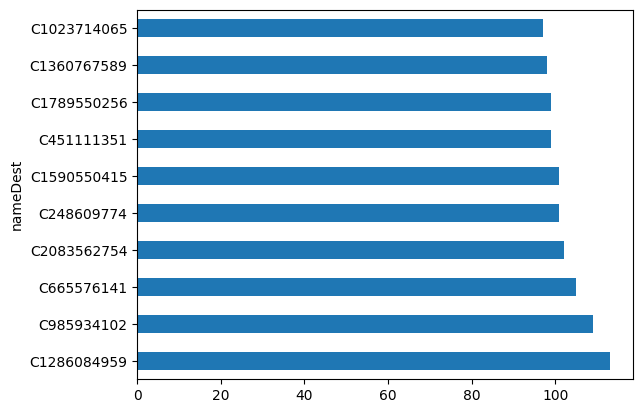

In [ ]:
fraudster[:10].plot(kind='barh')

## Step

<Axes: xlabel='step', ylabel='Density'>

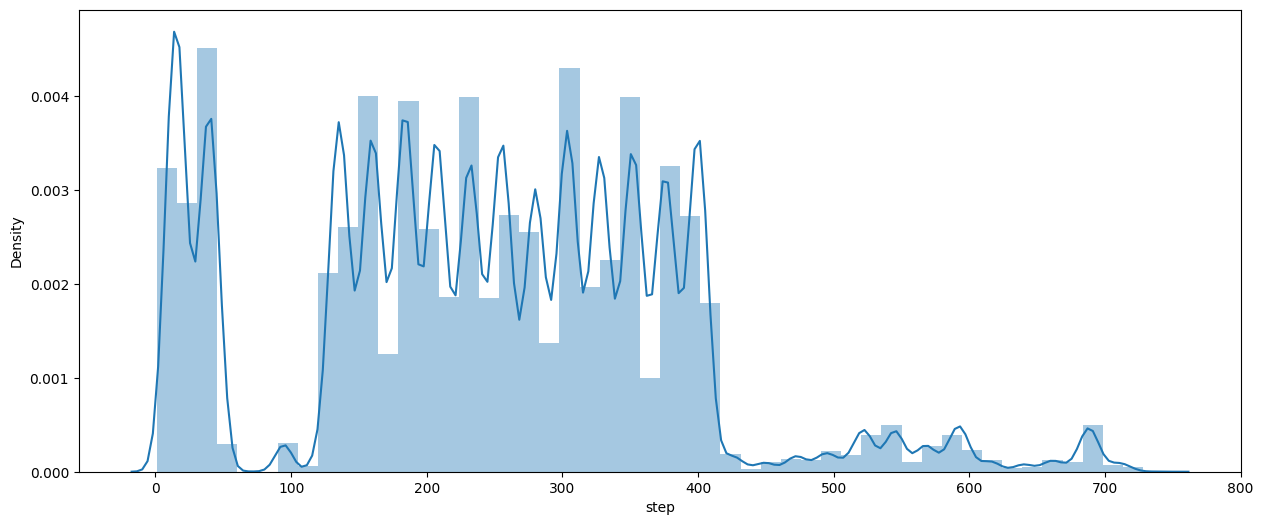

In [ ]:
plt.figure(figsize=(15, 6))
sns.distplot(df['step'], bins=50)

#### There is a maximum distribution of 150 to 400 of step

## Correlation between features

#calculate correlation matrix
corr = df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='Blues' ,fmt=".3f")

There is a high correlation between newbalanceOrig and oldbalanceOrg.

Also, between newbalanceDest and oldbalanceDest.

Apart from that, we have a relatively high correlation between amount and newbalanceDest and amount with oldbalanceDest# There is a high correlation between newbalanceOrig and oldbalanceOrg.

Also, between newbalanceDest and oldbalanceDest.

Apart from that, we have a relatively high correlation between amount and newbalanceDest and amount with oldbalanceDest

In [ ]:
onlinefraud['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


The class 0 is the legitimate transactions, and the class 1 is the fraudulent transactions. We can see that there are 1047433 legit transactions and 1142 fraudulent transactions. Since our aim is to predict the fraudulent transactions, we call it the positive class, and these fraudulent transactions are just 0.109% of the total transactions.

Hence, this dataset is highly unbalanced. If the dataset is left unbalanced, it can lead to biased models that are better at predicting the negative cases than the positive ones. Therefore we need to account for this imbalance by balancing this dataset for the maximum precision while predicting the Online transaction Frauds through our Models.

There are two ways we can achieve this:

Undersampling

Oversampling

We plan to use both the techniques in the data and later we will be seeing the results and deciding the technique that gives us better results.

## Separating the data for analysis

In [ ]:
legit_txns = onlinefraud[onlinefraud.isFraud == 0]
fraud_txns = onlinefraud[onlinefraud.isFraud == 1]

#### Checking the shape of the distributions

In [ ]:
print(legit_txns.shape)
print(fraud_txns.shape)

(6354407, 11)
(8213, 11)


## Checking the statistical measures of the data for comaprison after Undersampling

We take the Mean of all the columns and verify the data before and after undersampling because we need to check the difference in statistical measures both before and after the undersampling process.

In [ ]:
legit_txns.amount.describe()

,amount
count,6.354407e+06
mean,1.224220e+05
std,1.240375e+05
min,4.501300e+03
25%,1.336840e+04
50%,7.468472e+04
75%,2.083648e+05
max,3.654233e+05


In [ ]:
fraud_txns.amount.describe()

,amount
count,8213.000000
mean,259417.430392
std,134356.752394
min,4501.300000
25%,127091.330000
50%,365423.309000
75%,365423.309000
max,365423.309000


#### Building the new undersampled dataset

Since the number of fraudulent transactions is 8213, we take 8213 samples of the legit transactions and concatenate both of them to make a well-balanced dataset.

In [ ]:
legit_sample = legit_txns.sample(n=8213) # Samples 8213 transactions out of the legit transactions

undersampled_dataset = pd.concat([legit_sample, fraud_txns], axis=0) # Concatenates all the 8213 the fraud_txns and the 8213 samples of the legit txns

#### Checking the newly built undersampled dataset.

We can see the head, tail and counts of values and statistical measures of the newly built undersampled dataset.

In [ ]:
undersampled_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2307875,188,CASH_IN,92220.600,C192315002,102418.00,194638.60,C707978906,2914266.669,3194869.671,0,0
76225,10,TRANSFER,365423.309,C1323331664,3823.33,0.00,C2144240673,2582656.070,3194869.671,0,0
378084,17,CASH_IN,223714.050,C2106093614,833103.90,1056817.95,C1133105949,338984.020,115269.970,0,0
1841910,163,CASH_OUT,184934.790,C1618831079,31462.00,0.00,C76463246,2498232.100,2683166.880,0,0
901390,43,CASH_OUT,268655.810,C64349152,0.00,0.00,C1696193673,700200.560,968856.370,0,0


In [ ]:
undersampled_dataset.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.130,C786484425,339682.130,0.0,C776919290,0.000,339682.130,1,0
6362616,743,TRANSFER,365423.309,C1529008245,1822508.289,0.0,C1881841831,0.000,0.000,1,0
6362617,743,CASH_OUT,365423.309,C1162922333,1822508.289,0.0,C1365125890,68488.840,3194869.671,1,0
6362618,743,TRANSFER,365423.309,C1685995037,850002.520,0.0,C2080388513,0.000,0.000,1,0
6362619,743,CASH_OUT,365423.309,C1280323807,850002.520,0.0,C873221189,2914266.669,3194869.671,1,0


In [ ]:
undersampled_dataset['isFraud'].value_counts()

,count
isFraud,
0,8213
1,8213


The upper one is the means of the newly built undersampled dataset. The lower one (next) is the means of the original dataset.

We can compare the respective variable values, it really depends on the legit samples which the algorithm chooses for forming the new dataset at that particular runtime.

However, this is extremely data inefficient. The discarded data has important information regarding the negative examples.

Lets accept this undersampled dataset and move on to oversampling, which solves this problem.

### Oversampling the data

Using this technique for balancing the dataset, we will be creating synthetic copies of instances from the fraudulent transactions class.

The minority class is the class with fewer instances than the majority class. In our case, the minority class is the fraud transactions.

Techniques usually used for oversampling are Random Oversampling, SMOTE (Synthetic Minority Over-sampling Technique), and ADASYN (Adaptive Synthetic Sampling).

The choice of oversampling technique can depend on the characteristics of the dataset and the specific goals of the analysis. It is often recommended to try out multiple oversampling techniques and evaluate their performance on a validation set before selecting the most appropriate technique for a given problem.

Other oversampling techniques such as Random Oversampling and ADASYN (Adaptive Synthetic Sampling) can also be effective in balancing class distribution, but they work differently and may have different effects on the resulting model performance.

We will be using both the three techniques listed above and then see the one which gives us best results.

Since the way we are doing oversampling in this project (using imblearn library) requires us to do the training and testing split of the data, we perform the oversampling in the next section with each technique.

## Section 3: Data Splitting into Test and Training data

### 1. Undersampled dataset

#### Dividing the data into features & targets

In [ ]:
X = undersampled_dataset.drop(columns=['isFraud','type','nameDest','nameOrig'], axis=1) # Remove the class column from the undersampled dataset
print(X)

         step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2307875   188   92220.600     102418.000       194638.60     2914266.669   
76225      10  365423.309       3823.330            0.00     2582656.070   
378084     17  223714.050     833103.900      1056817.95      338984.020   
1841910   163  184934.790      31462.000            0.00     2498232.100   
901390     43  268655.810          0.000            0.00      700200.560   
...       ...         ...            ...             ...             ...   
6362615   743  339682.130     339682.130            0.00           0.000   
6362616   743  365423.309    1822508.289            0.00           0.000   
6362617   743  365423.309    1822508.289            0.00       68488.840   
6362618   743  365423.309     850002.520            0.00           0.000   
6362619   743  365423.309     850002.520            0.00     2914266.669   

         newbalanceDest  isFlaggedFraud  
2307875     3194869.671               0  
762

In [ ]:
Y = undersampled_dataset['isFraud']
print(Y)

2307875    0
76225      0
378084     0
1841910    0
901390     0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 16426, dtype: int64


#### Splitting into Testing and Training data

 The value 0.2 which we had set in the test_size while splitting the training and testing undersampled data.

In [ ]:
X_train_undersampled, X_test_undersampled, Y_train_undersampled, Y_test_undersampled = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
# parameters test_size means testing data should consist of only 20% of the transactions randomly out of the provided X and Y datasets
# stratify=Y means if For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=Y will make sure that your random split has 25% of 0's and 75% of 1's.
# random_state controls the randomness, it will be producing the similar results independent of the number of executions.

In [ ]:
print(X.shape, X_train_undersampled.shape, X_test_undersampled.shape)

(9355, 7) (7484, 7) (1871, 7)


### 2. Oversampled Dataset

Dividing the Original data into features & targets

In [ ]:
X = onlinefraud.drop(columns=['isFraud','type','nameDest','nameOrig'], axis=1)# Remove the class column from the main dataset
print(X)

         step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0           1    9839.640     170136.000       160296.36           0.000   
1           1    4501.300      21249.000        19384.72           0.000   
2           1    4501.300        181.000            0.00           0.000   
3           1    4501.300        181.000            0.00       21182.000   
4           1   11668.140      41554.000        29885.86           0.000   
...       ...         ...            ...             ...             ...   
6362615   743  339682.130     339682.130            0.00           0.000   
6362616   743  365423.309    1822508.289            0.00           0.000   
6362617   743  365423.309    1822508.289            0.00       68488.840   
6362618   743  365423.309     850002.520            0.00           0.000   
6362619   743  365423.309     850002.520            0.00     2914266.669   

         newbalanceDest  isFlaggedFraud  
0                 0.000               0  
1  

In [ ]:
Y = onlinefraud['isFraud']
print(Y)

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: uint8


#### Splitting Original Data into Testing and Training data

The value 0.2 which we had set in the test_size while splitting the training and testing undersampled data.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(6362620, 7) (5090096, 7) (1272524, 7)


### Technique 1 - SMOTE

SMOTE works by creating synthetic instances of the minority class by interpolating new instances between existing minority class instances. This technique helps to generate more diverse synthetic instances and can be particularly useful when dealing with non-linear decision boundaries.

Importing the dependencies and creation of SMOTE object

##### imblearn (Imbalanced Learn) is the Python library we will be using in this project for oversampling using different techniques.

In [ ]:
from imblearn.over_sampling import SMOTE #SMOTE = synthetic minority oversampling technique
smote = SMOTE() # create SMOTE Object

#### Splitting the dataset using SMOTE technique

In [ ]:
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
print(X_train_smote.shape)
print(Y_train_smote.shape)

(10167052, 7)
(10167052,)


The dataset has been oversampled and split into testing and training data using the SMOTE technique. We can observe that the number of transactions has increased to almost double.

Checking the number of fraud and legit transactions after oversampling We can only check for the number of fraud and legit transactions after oversampling if the oversampling is done before dropping the "Class" so that we can identify which is the fraud transaction and which is the legit transaction. Here we have removed that column before oversamping and hence we cant check for the number of fraud and legit transactions after oversampling.

### Technique 2 - ADASYN

Adaptive Synthetic Sampling is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples.

This method is similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled.

Importing the dependencies and creation of ADASYN object

In [ ]:
from imblearn.over_sampling import ADASYN #ADASYN = Adaptive Synthetic Sampling
adasyn = ADASYN(sampling_strategy='not majority', random_state=2) # create ADASYN Object

In [ ]:
X_train_adasyn, Y_train_adasyn = adasyn.fit_resample(X_train, Y_train)
print(X_train_adasyn.shape)
print(Y_train_adasyn.shape)

(10166862, 7)
(10166862,)


The dataset has been oversampled and split into testing and training data using the ADASYN technique. We can observe that the number of transactions has increased to almost double.

Checking the number of fraud and legit transactions after oversampling We can only check for the number of fraud and legit transactions after oversampling if the oversampling is done before dropping the "Class" so that we can identify which is the fraud transaction and which is the legit transaction. Here we have removed that column before oversamping and hence we cant check for the number of fraud and legit transactions after oversampling.

### Technique 3 - RANDOM OVERSAMPLING

We are also trying out the oversampling using random oversampling technique.

Importing the dependencies and creation of ROS object

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 2)

In [ ]:
X_train_ros, Y_train_ros = ros.fit_resample(X_train, Y_train)
print(X_train_ros.shape)
print(Y_train_ros.shape)

(10167052, 7)
(10167052,)


The dataset has been oversampled and split into testing and training data using the ROS technique. We can observe that the number of transactions has increased to almost double.

Checking the number of fraud and legit transactions after oversampling We can only check for the number of fraud and legit transactions after oversampling if the oversampling is done before dropping the "Class" so that we can identify which is the fraud transaction and which is the legit transaction. Here we have removed that column before oversamping and hence we cant check for the number of fraud and legit transactions after oversampling.

## Section 4 - Model Training

We will be training different kinds of models - Logistic Regression, Support Vector Machines, Naive Bayes, K-Nearest Neighbours, Decision Trees based on all the types of oversampled and undersampled training data.

Scaling the Undersampled Data

In [ ]:
scaler = StandardScaler()
X_train_scaled_undersampled = scaler.fit_transform(X_train_undersampled)
X_test_scaled_undersampled = scaler.transform(X_test_undersampled)

In [ ]:
X_train_scaled_smote = scaler.fit_transform(X_train_smote) # smote training data
X_train_scaled_adasyn = scaler.fit_transform(X_train_adasyn) # adasyn training data

X_train_scaled_ros = scaler.fit_transform(X_train_ros) # ros training data

X_test_scaled = scaler.transform(X_test) # original testing data

### Creating the Model instances/objects

In [ ]:
LogisticRegressionModel = LogisticRegression()

In [ ]:
SVM_SVC_Model_CLF = SVC(kernel='linear')

In [ ]:
NaiveBayes_Model_CLF = GaussianNB()

In [ ]:
KNN_Model_CLF = KNeighborsClassifier(n_neighbors=5)

In [ ]:
DecisionTree_Model = DecisionTreeClassifier()
params = {'max_depth': [2, 4, 6, 8, 10],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 2, 3, 4, 5]}
DecisionTree_GridSearch_CLF = GridSearchCV(DecisionTree_Model, params, cv=5)

### Training the Logistic Regression Model and seeing the classification results

#### 1. Over the Undersampled Data

In [ ]:
LogisticRegressionModel.fit(X_train_scaled_undersampled, Y_train_undersampled)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_undersampled)
LR_undersampling_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_undersampled)
print('Accuracy on Training data : ', LR_undersampling_training_data_accuracy)
LR_undersampling_training_data_classification_report = classification_report(X_train_prediction, Y_train_undersampled)
print('\nClassification Report on Training data : \n', LR_undersampling_training_data_classification_report)

Accuracy on Training data :  0.9041856925418569

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      7333
           1       0.85      0.96      0.90      5807

    accuracy                           0.90     13140
   macro avg       0.90      0.91      0.90     13140
weighted avg       0.91      0.90      0.90     13140



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled_undersampled)
LR_undersampling_test_data_accuracy = accuracy_score(X_test_prediction, Y_test_undersampled)
print('Accuracy score on Test Data : ', LR_undersampling_test_data_accuracy)
LR_undersampling_testing_data_classification_report = classification_report(X_test_prediction, Y_test_undersampled)
print('\nClassification Report on Training data : \n', LR_undersampling_testing_data_classification_report)

Accuracy score on Test Data :  0.9044430919050518

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      1815
           1       0.85      0.95      0.90      1471

    accuracy                           0.90      3286
   macro avg       0.90      0.91      0.90      3286
weighted avg       0.91      0.90      0.90      3286



#### 2. Over the oversampled data - SMOTE

In [ ]:
LogisticRegressionModel.fit(X_train_scaled_smote, Y_train_smote)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_smote)
LR_smote_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_smote)
print('Accuracy on Training data : ', LR_smote_training_data_accuracy)
LR_smote_training_data_classification_report = classification_report(X_train_prediction, Y_train_smote)
print('\nClassification Report on Training data : \n', LR_smote_training_data_classification_report)

Accuracy on Training data :  0.905202019228386

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91   5554370
           1       0.86      0.95      0.90   4612682

    accuracy                           0.91  10167052
   macro avg       0.91      0.91      0.90  10167052
weighted avg       0.91      0.91      0.91  10167052



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled)
LR_smote_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', LR_smote_test_data_accuracy)
LR_smote_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', LR_smote_testing_data_classification_report)

Accuracy score on Test Data :  0.9533902700459873

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98   1212051
           1       0.85      0.02      0.05     60473

    accuracy                           0.95   1272524
   macro avg       0.90      0.51      0.51   1272524
weighted avg       0.95      0.95      0.93   1272524



#### 3. Over the oversampled data - ADASYN

In [ ]:
LogisticRegressionModel.fit(X_train_scaled_adasyn, Y_train_adasyn)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_adasyn)
LR_adasyn_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_adasyn)
print('Accuracy on Training data : ', LR_adasyn_training_data_accuracy)
LR_adasyn_training_data_classification_report = classification_report(X_train_prediction, Y_train_adasyn)
print('\nClassification Report on Training data : \n', LR_adasyn_training_data_classification_report)

Accuracy on Training data :  0.9099704510595304

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91   5051898
           1       0.91      0.91      0.91   5114964

    accuracy                           0.91  10166862
   macro avg       0.91      0.91      0.91  10166862
weighted avg       0.91      0.91      0.91  10166862



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled)
LR_adasyn_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', LR_adasyn_test_data_accuracy)
LR_adasyn_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', LR_adasyn_testing_data_classification_report)

Accuracy score on Test Data :  0.9981642782375814

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270181
           1       0.50      0.35      0.41      2343

    accuracy                           1.00   1272524
   macro avg       0.75      0.68      0.71   1272524
weighted avg       1.00      1.00      1.00   1272524



#### 4. Over the oversampled data - ROS

In [ ]:
LogisticRegressionModel.fit(X_train_scaled_ros, Y_train_ros)

LogisticRegression()

In [ ]:
# accuracy on training data
X_train_prediction = LogisticRegressionModel.predict(X_train_scaled_ros)
LR_ros_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_ros)
print('Accuracy on Training data : ', LR_ros_training_data_accuracy)
LR_ros_training_data_classification_report = classification_report(X_train_prediction, Y_train_ros)
print('\nClassification Report on Training data : \n', LR_ros_training_data_classification_report)

Accuracy on Training data :  0.9052604432435282

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91   5602438
           1       0.85      0.95      0.90   4564614

    accuracy                           0.91  10167052
   macro avg       0.91      0.91      0.91  10167052
weighted avg       0.91      0.91      0.91  10167052



In [ ]:
# accuracy on test data
X_test_prediction = LogisticRegressionModel.predict(X_test_scaled)
LR_ros_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', LR_ros_test_data_accuracy)
LR_ros_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', LR_ros_testing_data_classification_report)

Accuracy score on Test Data :  0.9561257783743174

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98   1215534
           1       0.85      0.02      0.05     56990

    accuracy                           0.96   1272524
   macro avg       0.90      0.51      0.51   1272524
weighted avg       0.95      0.96      0.94   1272524



### Training the Decision Trees model and seeing the classification results

#### 1. Over the undersampled data

In [ ]:
DecisionTree_Model.fit(X_train_scaled_undersampled, Y_train_undersampled)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_undersampled)
DT_undersampling_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_undersampled)
print('Accuracy on Training data : ', DT_undersampling_training_data_accuracy)
DT_undersampling_training_data_classification_report = classification_report(X_train_prediction, Y_train_undersampled)
print('\nClassification Report on Training data : \n', DT_undersampling_training_data_classification_report)

Accuracy on Training data :  0.999923896499239

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6571
           1       1.00      1.00      1.00      6569

    accuracy                           1.00     13140
   macro avg       1.00      1.00      1.00     13140
weighted avg       1.00      1.00      1.00     13140



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled_undersampled)
DT_undersampling_test_data_accuracy = accuracy_score(X_test_prediction, Y_test_undersampled)
print('Accuracy score on Test Data : ', DT_undersampling_test_data_accuracy)
DT_undersampling_testing_data_classification_report = classification_report(X_test_prediction, Y_test_undersampled)
print('\nClassification Report on Training data : \n', DT_undersampling_testing_data_classification_report)

Accuracy score on Test Data :  0.983262325015216

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1624
           1       0.99      0.98      0.98      1662

    accuracy                           0.98      3286
   macro avg       0.98      0.98      0.98      3286
weighted avg       0.98      0.98      0.98      3286



#### 2. Over the oversampled data - SMOTE

In [ ]:
DecisionTree_Model.fit(X_train_scaled_smote, Y_train_smote)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_smote)
DT_smote_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_smote)
print('Accuracy on Training data : ', DT_smote_training_data_accuracy)
DT_smote_training_data_classification_report = classification_report(X_train_prediction, Y_train_smote)
print('\nClassification Report on Training data : \n', DT_smote_training_data_classification_report)

Accuracy on Training data :  0.9999451168342604

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083974
           1       1.00      1.00      1.00   5083078

    accuracy                           1.00  10167052
   macro avg       1.00      1.00      1.00  10167052
weighted avg       1.00      1.00      1.00  10167052



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled)
DT_smote_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', DT_smote_test_data_accuracy)
DT_smote_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', DT_smote_testing_data_classification_report)

Accuracy score on Test Data :  0.9663495541145

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98   1228426
           1       0.89      0.03      0.06     44098

    accuracy                           0.97   1272524
   macro avg       0.93      0.52      0.52   1272524
weighted avg       0.96      0.97      0.95   1272524



#### 3. Over the oversampled data - ADASYN

In [ ]:
DecisionTree_Model.fit(X_train_scaled_adasyn, Y_train_adasyn)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_adasyn)
DT_adasyn_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_adasyn)
print('Accuracy on Training data : ', DT_adasyn_training_data_accuracy)
DT_adasyn_training_data_classification_report = classification_report(X_train_prediction, Y_train_adasyn)
print('\nClassification Report on Training data : \n', DT_adasyn_training_data_classification_report)

Accuracy on Training data :  0.9998449865848479

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5084550
           1       1.00      1.00      1.00   5082312

    accuracy                           1.00  10166862
   macro avg       1.00      1.00      1.00  10166862
weighted avg       1.00      1.00      1.00  10166862



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled)
DT_adasyn_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', DT_adasyn_test_data_accuracy)
DT_adasyn_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', DT_adasyn_testing_data_classification_report)

Accuracy score on Test Data :  0.9706614570727153

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99   1235611
           1       0.37      0.02      0.03     36913

    accuracy                           0.97   1272524
   macro avg       0.67      0.51      0.51   1272524
weighted avg       0.95      0.97      0.96   1272524



#### 4. Over the oversampled data - ROS

In [ ]:
DecisionTree_Model.fit(X_train_scaled_ros, Y_train_ros)

DecisionTreeClassifier()

In [ ]:
# accuracy on training data
X_train_prediction = DecisionTree_Model.predict(X_train_scaled_ros)
DT_ros_training_data_accuracy = accuracy_score(X_train_prediction, Y_train_ros)
print('Accuracy on Training data : ', DT_ros_training_data_accuracy)
DT_ros_training_data_classification_report = classification_report(X_train_prediction, Y_train_ros)
print('\nClassification Report on Training data : \n', DT_ros_training_data_classification_report)

Accuracy on Training data :  0.9998382028536885

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083497
           1       1.00      1.00      1.00   5083555

    accuracy                           1.00  10167052
   macro avg       1.00      1.00      1.00  10167052
weighted avg       1.00      1.00      1.00  10167052



In [ ]:
# accuracy on test data
X_test_prediction = DecisionTree_Model.predict(X_test_scaled)
DT_ros_test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score on Test Data : ', DT_ros_test_data_accuracy)
DT_ros_testing_data_classification_report = classification_report(X_test_prediction, Y_test)
print('\nClassification Report on Training data : \n', DT_ros_testing_data_classification_report)

Accuracy score on Test Data :  0.9993438237707108

Classification Report on Training data : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270718
           1       0.80      0.72      0.76      1806

    accuracy                           1.00   1272524
   macro avg       0.90      0.86      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524

